In [913]:
from IPython.display import Image
Image(url='img/FB5_banner.png', width = 800)

# Instructions

In this competition, you are going to predict which business a user is checking into based on their location, accuracy, and timestamp.

The train and test dataset are split based on time, and the public/private leaderboard in the test data are split randomly. There is no concept of a person in this dataset. All the row_id's are events, not people. 

**Note:** Some of the columns, such as time and accuracy, are intentionally left vague in their definitions. Please consider them as part of the challenge. 

# File descriptions

**train.csv, test.csv**
- row_id: id of the check-in event
- x y: coordinates
- accuracy: location accuracy 
- time: timestamp
- place_id: id of the business, **this is the target you are predicting**

**sample_submission.csv**
- a sample submission file in the correct format with random predictions

# Loading data

In [511]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pylab
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import LabelEncoder
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
## File paths
sample_submission_filename = 'data/sample_submission.csv'
test_filename = 'data/test.csv'
train_filename = 'data/train.csv'
## Loading the data
sample_submission_df = pd.read_csv(sample_submission_filename)
train_df = pd.read_csv(train_filename)
test_df = pd.read_csv(test_filename)

In [512]:
print "Size of training set:", train_df.shape
print "Size of test set:", test_df.shape

Size of training set: (29118021, 12)
Size of test set: (8607230, 11)


In [516]:
train_df.head()

,row_id,x,y,accuracy,time,place_id,hour,weekday,month,year,day,grid_cell
0,0,0.7941,9.0809,54,470702,8523065625,21.033333,4.876389,10.895880,0.895552,326.876389,721
1,1,5.9567,4.7968,13,186555,1757726713,13.250000,3.552083,4.318403,0.354937,129.552083,391
2,2,8.3078,7.0407,74,322648,1137537235,1.466667,0.061111,7.468704,0.613866,224.061111,576
3,3,7.3665,2.5165,65,704587,6567393236,7.116667,6.296528,4.309884,1.340538,124.296528,214
4,4,4.0961,1.1307,31,472130,7440663949,20.833333,5.868056,10.928935,0.898269,327.868056,88


Notice that time is given to us simply as a numeric value. There have been quite a few great scripts exploring the timestamp and the unit of time here is almost certainly minutes. Since businesses tend to run on daily cycles let’s extract a new feature called hour that gives the hour in the day (from 0 to 24). Let’s also extract (approximations) of other time units such as weekday, month and year.

In [514]:
train_df = add_time_features(train_df)
test_df = add_time_features(test_df)

Now we’ll select a subset of the data - I’ll just pick a random 250 meters by 250 meters square in our imaginary Facebook city.

In [532]:
sub_train_df = train_df[(train_df['x']>1) & 
                           (train_df['x']<1.25) & 
                           (train_df['y']>2.5) &
                           (train_df['y']<2.75)]

We will split our dataset into a training and validation set so we can check the results. We choose the validation set to be the more recent check-ins so that our validation structure is similar to the one kaggle does behind the scenes on the test set.

In [533]:
small_train_df = sub_train_df[sub_train_df['time'] < 7.3e5]
small_val_df = sub_train_df[sub_train_df['time'] >= 7.3e5] 

# Exploratory Analysis

Let’s take a look at our training set:

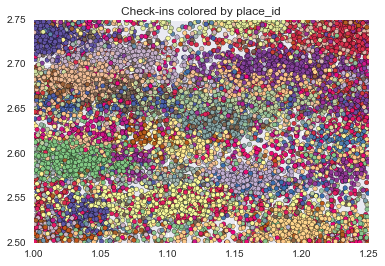

In [546]:
plt.scatter(x=small_train_df['x'], y=small_train_df['y'],
            c=small_train_df['place_id'], cmap=plt.cm.Accent)
plt.axis([1, 1.25, 2.5, 2.75])
plt.title('Check-ins colored by place_id')
plt.show()

Ok, so the clusters are pretty visible, however there seems to be quite a lot of overlap - the place_id’s are definitely not separable. Let’s try plotting them using the hour component as our third variable. We will just look at the most popular clusters outherwise it gets really messy:

In [541]:
## We select the most popular places id
count_id = small_train_df['place_id'].value_counts(dropna = False)
top_places_500 = count_id[count_id[:] > 500].index.values
small_train_df_top = small_train_df[small_train_df['place_id'].isin(top_places_500)]

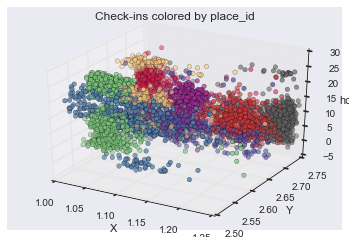

In [542]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=small_train_df_top['x'], ys=small_train_df_top['y'],
            zs=small_train_df_top['hour'], c=small_train_df_top['place_id'],
            cmap=plt.cm.Accent)
ax.axis([1, 1.25, 2.5, 2.75])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('hour')
plt.title('Check-ins colored by place_id')
plt.show()

Whoa very cool! Adding the time dimension definitely helps. The daily cycles are clearly visible above - for certain places the check in’s stop for a few hours and then start picking up again. Other businesses have quite a few peaks throughtout the day, and the peaks tend to be rather different for different businesses. Also keep in mind that the upper z-square (z = 24) and the lower z-square (z = 0) are really the same thing since time of day is, well, prediodic. So really this thing we’re looking at is better viewed not as a cube but as a (flat) solid torus!

Let’s also take a look at day of week:

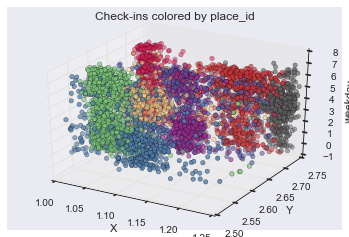

In [543]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=small_train_df_top['x'], ys=small_train_df_top['y'],
            zs=small_train_df_top['weekday'], c=small_train_df_top['place_id'],
            cmap=plt.cm.Accent)
ax.axis([1, 1.25, 2.5, 2.75])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('weekday')
plt.title('Check-ins colored by place_id')
plt.show()

There is some variation by day of week (perhaps some businesses are busier on the weekend) but the most visibile trend is still the day cycles.

Can we see similar trend for accuracy?

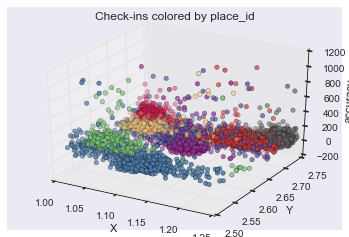

In [544]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=small_train_df_top['x'], ys=small_train_df_top['y'],
            zs=small_train_df_top['accuracy'], c=small_train_df_top['place_id'],
            cmap=plt.cm.Accent)
ax.axis([1, 1.25, 2.5, 2.75])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('accuracy')
plt.title('Check-ins colored by place_id')
plt.show()

However we still might have too many classes for something like random forest to work at its best. Let’s check it out:

In [545]:
print "Number of unique place_id:", len(small_train_df['place_id'].unique())

Number of unique place_id: 770


Let’s for now remove the place_id’s that have only three or less occurences in the city are we picked. This will decrease the number of classes by a lot. Since we have a validation set we can always come back and change the filter level to see if we get better results.

In [534]:
count_id = small_train_df['place_id'].value_counts(dropna = False)
top_places = count_id[count_id[:] > 3].index.values
small_train_top_df = small_train_df[small_train_df['place_id'].isin(top_places)]

In [535]:
print "Number of rows:", small_train_top_df.shape[0]
print "Number of unique place_id after filtering:", len(small_train_top_df['place_id'].unique())

Number of rows: 15595
Number of unique place_id after filtering: 224


Sweet, now we have **15595** training examples and **224** classes and we’re ready to do some machine learning!

# Make predictions on subset of data

In [673]:
%run functions.py

## Prepare subset of data

In [862]:
fw=[500, 1000, 4, 2.5, 1./22., 4, 9, 1./100] # features weights
train_df_clean, test_df_clean, X_train, y_train = prepare_data(small_train_df, small_val_df, fw=fw)

Preparing train data
Preparing test data


In [858]:
train_df_clean.head()

,x,y,hour,weekday,day,month,year,accuracy,grid_cell,place_id
600,610.70,2702.3,38.666667,8.506944,2.063763,6.053704,1.119521,0.17,506,6683426742
4345,596.75,2655.0,80.133333,12.086806,12.628851,37.044630,6.850719,0.11,505,6889790653
4735,572.60,2607.4,60.200000,1.567708,16.255777,47.683611,8.818202,0.49,505,6822359752
6090,557.00,2626.2,4.466667,7.616319,4.593024,13.472870,2.491558,0.11,505,4000153867
6234,572.45,2500.3,67.800000,6.765625,9.986648,29.294167,5.417414,0.34,505,3741484405


## K Nearest Neighbors

The simplest thing to try in this case is probably K Nearest Neighbors. I was a little skeptical about it at first but it works surprisingly well for this problem (I added this section inspired by Sandro’s great script here).

The tricky part is figuring out the optimal weights for scaling your variables since knn is sensitive to the magnitutde of variables. The weights below are a combination of using a validation set (not the one here) and eye-balling.

In [899]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_test_pred_knn = knn.predict(X_test)

In [900]:
print "Mean accuracy of this model:", mean(y_test_pred_knn == y_test)

Mean accuracy of this model: 0.528539659007


That’s a pretty good accuracy (**0.528**) I think for a model as simple as knn. Let’s see if we can do do any better with a fancier method.

## Adaboost

In [892]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=1000),
                         algorithm="SAMME",
                         n_estimators=50)
bdt.fit(X_train, y_train)
y_test_pred_bdt = bdt.predict(X_test)

In [894]:
print "Mean accuracy of this model:", mean(y_test_pred_bdt == y_test)

 Mean accuracy of this model: 0.50852483321


## Random Forest

Let’s use the random forest algorithm.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators = 100, verbose=3)
rdf.fit(X_train, y_train)
y_test_pred_rdf = rdf.predict(X_test)

In [456]:
print "Mean accuracy of this model:", mean(y_test_pred_rdf == y_test)

Mean error of this model: 0.56338028169


We get an accuracy of **0.5633**. Hey not bad! Keep in mind that the evaluation metric for this competition is mean average precision at 3 so predicting votes/probabilities by class and then counting the top three id’s is guaranteed to improve our score. But for simplicity we’ll just stick to accuracy.

Let’s take take a look at the predictions on the validation set:

## Where do we get wrong predictions?

/Users/ameicler/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


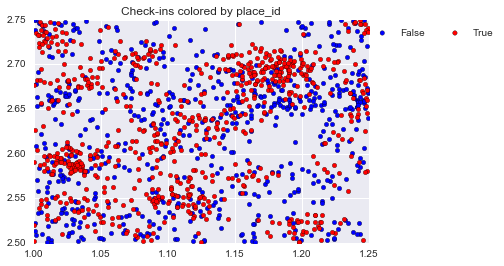

In [902]:
small_val_df['correct'] = y_test_pred_knn == y_test
plt.scatter(x=small_val_df[small_val_df['correct'] == False]['x'],
            y=small_val_df[small_val_df['correct'] == False]['y'],
            c='b', cmap=plt.cm.Accent, label = False)
plt.scatter(x=small_val_df[small_val_df['correct'] == True]['x'],
            y=small_val_df[small_val_df['correct'] == True]['y'],
            c='r', cmap=plt.cm.Accent, label = True)
plt.axis([1, 1.25, 2.5, 2.75])
plt.title('Check-ins colored by place_id')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0),
          ncol=3, fancybox=True, shadow=True)
plt.show()

It does seem that the correctly identified check-ins are more “clustered” while the wrongly identified ones are more uniformly distributed but other than that no clear patters here.

What if we looked at it in 3D (with accuracy in height for example)

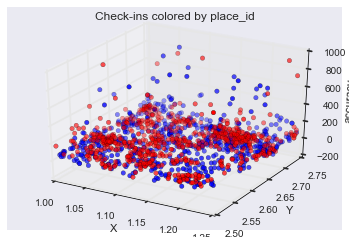

In [912]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=small_val_df[small_val_df['correct'] == False]['x'],
           ys=small_val_df[small_val_df['correct'] == False]['y'],
           zs=small_val_df[small_val_df['correct'] == False]['accuracy'],
           c='b',
           cmap=plt.cm.Accent,
           label=False)
ax.scatter(xs=small_val_df[small_val_df['correct'] == True]['x'],
           ys=small_val_df[small_val_df['correct'] == True]['y'],
           zs=small_val_df[small_val_df['correct'] == True]['accuracy'],
           c='r',
           cmap=plt.cm.Accent,
           label=True)
ax.axis([1, 1.25, 2.5, 2.75])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('accuracy')
plt.title('Check-ins colored by place_id')
plt.show()

In [921]:
print "Avg(accuracy) on wrong data points:", \
    small_val_df[small_val_df['correct'] == False]['accuracy'].mean()
print "Avg(accuracy) on correct data points:", \
    small_val_df[small_val_df['correct'] == True]['accuracy'].mean()

Avg(accuracy) on wrong data points: 110.11163522
Avg(accuracy) on correct data points: 87.0182328191


Let’s also take a look at what kind of id’s our model gets wrong. To do this we will look at accuracy by id and also plot the id’s based on how often they appear in the validation set. We see below that our model is doing actually really great on the more popular id’s(more blue on the right). However it loses when it looks at id’s that appear only a few times.

In [922]:
## Histogram of place id sorted undescending and with distinction of correct and wrong predictions

# Generate a submission for the challenge

In [508]:
##Preparing whole set of data
fw = [500, 1000, 4, 3, 1./22., 4, 10, 1./90]
prepare_data(train_df, test_df, fw=fw)

Preparing train data
Preparing test data


In [510]:
##Defining the parameters
n_cell_x = 20
n_cell_y = 40 
th = 5
##Solving classification problems inside each grid cell
process_grid(train_df_clean, test_df_clean, th, n_cell_x*n_cell_y)

iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
Generating submission file ...


This generates a score of **0.55242** (currently in **204th position**)! Best score is **0.60902**


# Sources

Inspired by the great work made by [Sandro Vega-Pons](https://www.kaggle.com/svpons) and [Alexandru Papiu](https://www.kaggle.com/apapiu) on the same competition